In [156]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Input, Dense, Lambda
from tensorflow.keras.layers import Add, Concatenate, Reshape, Flatten, Multiply
from tensorflow.keras.models import Model

## Equations of motion

In [157]:
k = 1.0
gamma = 0.0
m = 1

f = lambda x: -(k*x + gamma*x**3)
SHO_equations = lambda t, X: [X[1]/m, f(X[0])]

## Dataset construction

## RK4 Solver

In [158]:
def rk4_step(dX_dt, n_params):
    
    in_tensor = Input(shape=(n_params+1,))
    
    h  = Lambda(lambda x: x[:,0]) (in_tensor) 
    X0 = Lambda(lambda x: x[:,1:])(in_tensor)
    
    k1 = dX_dt(X0)
    k2 = dX_dt(Add()([X0, Lambda(lambda k: (h/2)*k)(k1)]))
    k3 = dX_dt(Add()([X0, Lambda(lambda k: (h/2)*k)(k2)]))
    k4 = dX_dt(Add()([X0, Lambda(lambda k: h*k)(k3)]))
    
    k5 = Add()([k1,Lambda(lambda k: 2*k)(k2),
                Lambda(lambda k: 2*k)(k3),k4])
    
    dX = Lambda(lambda k: (h/6)*k)(k5)
    
    X1 = Add()([X0, dX])
    
    out_tensor = Concatenate()([Reshape((1,))(h), X1])
    
    return Model(inputs=in_tensor, outputs=out_tensor)

In [159]:
def hamiltonian_time_evolution(n_dims):
    X = Input(shape=(2*n_dims,))

    Q = Lambda(lambda x: x[:,0:n_dims])(X)
    P = Lambda(lambda x: x[:,n_dims:2*n_dims])(X)

    T = Lambda(lambda p: (1/(2*m))*p**2)(P)
    V = Lambda(lambda q: (k/2)*q**2 + (gamma/4)*q**4)(Q)
    #V = potential(Q)
    
    H = Add()([T, V])
    
    grad = Lambda(lambda x: tf.gradients(x[0],x[1]))([H,[P,Q]])
    
    dPQdt = Concatenate()([grad[0], -grad[1]])

    return Model(inputs=X, outputs=dPQdt)

In [160]:
n_dims = 1

dX_dt = hamiltonian_time_evolution(n_dims)
model = rk4_step(dX_dt, 2*n_dims)

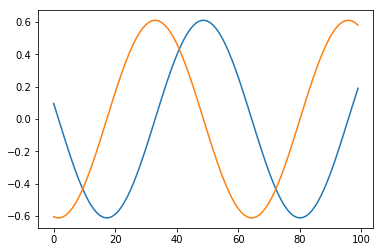

In [161]:
xp = np.insert(np.random.randn(2*n_dims), 0, 0.1).reshape((1,1+2*n_dims))
x = []

for i in range (100):
    x += [xp[0][1:]]
    xp = model.predict([xp])
    
plt.plot(np.array(x))